# Import

In [1]:
# Загрузка библиотек
import numpy as np
import pandas as pd
import re
from itertools import combinations
from statsmodels.stats import weightstats 

import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from tqdm import tqdm
tqdm.pandas(desc="Progress:")

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import silhouette_score, mean_absolute_error

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Фиксация random seed для воспроизводимости экспериментов
RS = 42

In [3]:
# Фиксация версии пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Загрузка данных в переменные
train = pd.read_csv('main_task.csv')
valid = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Объединяем данные, помячая тренировочные
train['train'] = 1
valid['train'] = 0
valid['Rating'] = 0.
data = train.append(valid, sort=False).reset_index(drop=True)

# Первичный взгляд на данные

In [5]:
sample_submission.sample(5)

,Restaurant_id,Rating
7907,id_7907,2.0
6953,id_6953,1.0
7755,id_7755,2.0
5771,id_5771,2.0
6913,id_6913,3.0


In [6]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train
20218,id_2092,Warsaw,['Thai'],2093.0,5.0,$,NaN,"[['Great icecream! Something different!'], ['0...",/Restaurant_Review-g274856-d12662545-Reviews-L...,d12662545,1
39989,id_8887,London,['International'],8896.0,5.0,NaN,NaN,"[['I love this place!'], ['08/24/2015']]",/Restaurant_Review-g186338-d5550626-Reviews-Th...,d5550626,1
43566,id_3566,Dublin,"['European', 'Italian', 'Pizza']",1012.0,0.0,$$ - $$$,32.0,"[['Loved it- will return !!', 'Best family res...",/Restaurant_Review-g186605-d4475567-Reviews-Mi...,d4475567,0
12309,id_12233,London,['International'],12243.0,4.0,$$ - $$$,40.0,"[['Good location, average food', 'Reliable bre...",/Restaurant_Review-g186338-d1989966-Reviews-Th...,d1989966,1
43187,id_3187,London,"['Bar', 'British', 'Pub', 'Grill', 'Vegetarian...",1183.0,0.0,$$ - $$$,483.0,"[['Great pub', 'Great for a pint'], ['11/16/20...",/Restaurant_Review-g186338-d1044372-Reviews-Le...,d1044372,0


## Описание полей

- Restaurant_id - ID
- City - Город 
- Cuisine Style - Кухня
- Ranking - Ранг ресторана относительно других ресторанов в этом городе
- Price Range - Цены в ресторане в 3 категориях
- Number of Reviews - Количество отзывов
- Reviews - 2 последних отзыва и даты этих отзывов
- URL_TA - Cтраница ресторана на 'www.tripadvisor.com' 
- ID_TA - ID ресторана в TripAdvisor
- Rating - Рейтинг ресторана

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Rating             50000 non-null  float64
 5   Price Range        32639 non-null  object 
 6   Number of Reviews  46800 non-null  float64
 7   Reviews            49998 non-null  object 
 8   URL_TA             50000 non-null  object 
 9   ID_TA              50000 non-null  object 
 10  train              50000 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Бросается в глаза, признаки 'Cuisine Style' и 'Reviews' являют списками. В частности, в 'Reviews' есть даты. Для корректной работы необходимо извлечь из них полезную иформацию.

## Пропуски

In [8]:
# Функция возвращяет визуализацию и относительную долю пропусков в данных
def na_values(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(df.isnull(),
                yticklabels=False, 
                cbar=False,
                cmap='viridis')
    plt.show()
    
    for column in df.columns:
        value = df[column].isna().sum()
        if value > 0:
            print(column.upper())
            print('%% пропущенных данных в столбце: \t{}'.format(np.round(value/len(df[column])*100), 2))
            print('(%% от общего кол-ва данных: \t{})'.format(np.round(value/np.product(df.shape)*100), 2))
            print()

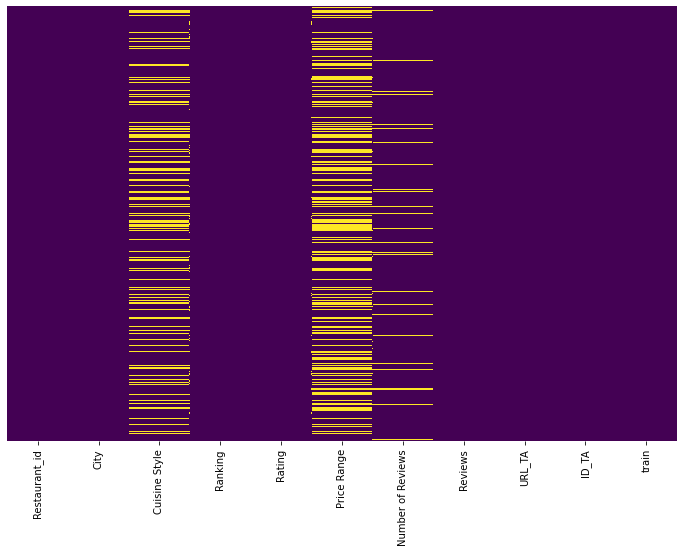

CUISINE STYLE
%% пропущенных данных в столбце: 	23.0
(%% от общего кол-ва данных: 	2.0)

PRICE RANGE
%% пропущенных данных в столбце: 	35.0
(%% от общего кол-ва данных: 	3.0)

NUMBER OF REVIEWS
%% пропущенных данных в столбце: 	6.0
(%% от общего кол-ва данных: 	1.0)

REVIEWS
%% пропущенных данных в столбце: 	0.0
(%% от общего кол-ва данных: 	0.0)



In [9]:
na_values(data)

Более трети строк содержит пропуски. Перед тем как приступать к моделированию, будет необходимо их заполнить.

## ID дубликаты

Имеется три признака, которые должны быть уникальны для каждого ресторана:

    - 'Restaurant_id'
    - 'URL_TA'
    - 'ID_TA'
Имеет смысл проверить уникальность и удалить неинформативные признаки

In [10]:
# Функция возвращает %% уникальных зачений для выбранных признаков
def unique_id_check(df, cols):
    for col in cols:
        print(col.upper())
        print('%% уникальных значений в столбце: \t{}'.format(np.round(len(df[col].unique())/df.shape[0]*100, 2)))
        print()

In [11]:
unique_id_check(train, ['Restaurant_id','URL_TA','ID_TA'])

RESTAURANT_ID
%% уникальных значений в столбце: 	29.77

URL_TA
%% уникальных значений в столбце: 	99.95

ID_TA
%% уникальных значений в столбце: 	99.95



Значения не уникальны для всех трех признаков. Имеет смысл проверить, одинаковы ли дубликаты для 'URL_TA' и 'ID_TA'. И разобраться почему 'Restaurant_id' уникально меньше, чем для трети ресторанов.

In [12]:
# Фунция возвращает дупликаты для наиболее уникального признака из списка
def cross_duplicates(df, cols):
    max_value = 0
    for col in cols:
        if len(train[col].unique()) >= max_value:
            max_value = len(train[col].unique())
            base = col
    cols.remove(base)
    dups = df[df[base].duplicated() == True][base].values
    
    for col in cols:
        count = 0
        for i in dups:
            if len(df[df[base] == i][col].unique()) > 1:
                print('Несколько значений {} для {} = {}'.format(col.upper(), 
                                                                 base.upper(), i))
                count += 1
        if count == 0:
            print('Значения {} уникальны для каждого {}'.format(col.upper(), base.upper()))

In [13]:
cross_duplicates(train, ['Restaurant_id','URL_TA','ID_TA'])

Несколько значений RESTAURANT_ID для ID_TA = d4600226
Несколько значений RESTAURANT_ID для ID_TA = d11674463
Несколько значений RESTAURANT_ID для ID_TA = d11921719
Несколько значений RESTAURANT_ID для ID_TA = d9802625
Несколько значений RESTAURANT_ID для ID_TA = d9877640
Несколько значений RESTAURANT_ID для ID_TA = d7809594
Несколько значений RESTAURANT_ID для ID_TA = d987900
Несколько значений RESTAURANT_ID для ID_TA = d2477531
Несколько значений RESTAURANT_ID для ID_TA = d1315077
Несколько значений RESTAURANT_ID для ID_TA = d11698990
Несколько значений RESTAURANT_ID для ID_TA = d13002276
Несколько значений RESTAURANT_ID для ID_TA = d3685055
Несколько значений RESTAURANT_ID для ID_TA = d697406
Несколько значений RESTAURANT_ID для ID_TA = d11999956
Несколько значений RESTAURANT_ID для ID_TA = d8753348
Несколько значений RESTAURANT_ID для ID_TA = d7337366
Несколько значений RESTAURANT_ID для ID_TA = d7342803
Несколько значений RESTAURANT_ID для ID_TA = d793170
Несколько значений RESTAUR

Признаки 'URL_TA' и 'ID_TA'  дублируют друг друга. Что касается 'Restaurant_id', необходимо рассмотреть случаи, когда для 'ID_TA' данный признак разный и наоборот.

In [14]:
# Пример, когда для одного 'ID_TA' несколько 'Restaurant_id'
train[train.ID_TA=='d4600226']

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train
147,id_4110,Madrid,['Spanish'],4112.0,5.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226,1
9446,id_4104,Madrid,['Spanish'],4106.0,5.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187514-d4600226-Reviews-Ca...,d4600226,1


In [15]:
# Разброс рейтинга для одинаковых 'ID_TA'
idd = train[train['ID_TA'].duplicated() == True]
idd = pd.concat([idd, train[train['ID_TA'].duplicated(keep='last') == True]])
(idd.groupby('ID_TA').Rating.max() - 
 idd.groupby('ID_TA').Rating.min()).value_counts(normalize = True)

0.0    1.0
Name: Rating, dtype: float64

In [16]:
# Пример, когда для одного 'Restaurant_id' при нескольких 'ID_TA' и 'URL_TA'
# Для удобства выведены первые 5 примеров и ссылок
r_id_dups = train[train['Restaurant_id'].duplicated() == True]['Restaurant_id'].unique()
example = train[train['Restaurant_id'] == r_id_dups[0]].URL_TA.values
display(train[train['Restaurant_id'] == r_id_dups[0]].head(5))
example[:5]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,train
140,id_2044,Barcelona,"['Italian', 'Mediterranean']",2045.0,4.5,$$ - $$$,89.0,"[['Real Sicilian cuisine', 'A really nice surp...",/Restaurant_Review-g187497-d8118086-Reviews-Or...,d8118086,1
174,id_2044,Budapest,['Italian'],2045.0,3.5,NaN,5.0,"[[], []]",/Restaurant_Review-g274887-d10498197-Reviews-P...,d10498197,1
3030,id_2044,London,"['Asian', 'Thai', 'Vegetarian Friendly', 'Vega...",2048.0,4.5,$$ - $$$,75.0,"[['Hidden up a little alley ....', 'Best ribs'...",/Restaurant_Review-g186338-d11838055-Reviews-S...,d11838055,1
20646,id_2044,Vienna,NaN,2046.0,4.5,NaN,7.0,"[['Bio taste', 'Perfect to begin the day!'], [...",/Restaurant_Review-g190454-d8811567-Reviews-Ka...,d8811567,1
20653,id_2044,Stockholm,NaN,2047.0,3.5,NaN,2.0,"[['OK coffee', 'A lucky find of great coffee']...",/Restaurant_Review-g189852-d9702108-Reviews-Ol...,d9702108,1


array(['/Restaurant_Review-g187497-d8118086-Reviews-Origano_cucina_siciliana-Barcelona_Catalonia.html',
       '/Restaurant_Review-g274887-d10498197-Reviews-Pizza_Escobar-Budapest_Central_Hungary.html',
       '/Restaurant_Review-g186338-d11838055-Reviews-Siam_Secret-London_England.html',
       '/Restaurant_Review-g190454-d8811567-Reviews-Kaas_Am_Markt-Vienna.html',
       '/Restaurant_Review-g189852-d9702108-Reviews-Olas_Kaffebar-Stockholm.html'],
      dtype=object)

In [17]:
# HTML - запрос на tripadvisor.com, вывод заголовков страниц
for i in range(5):
    url = 'https://www.tripadvisor.com'+example[i]
    response = requests.get(url)
    page = BeautifulSoup(response.text, 'html.parser')
    print(page.find('h1').text)

Best Restaurants in Barcelona, Province of Barcelona
Pizza Escobar, Budapest
Siam Garden, London
Kaas Am Markt, Vienna
Best Restaurants in Stockholm, Stockholm County


In [18]:
# Разброс рейтинга для одинаковых 'Restaurant_id'
rid = train[train['Restaurant_id'].duplicated() == True]
rid = pd.concat([rid, train[train['Restaurant_id'].duplicated(keep='last') == True]])
(rid.groupby('Restaurant_id').Rating.max() - 
 rid.groupby('Restaurant_id').Rating.min()).value_counts(normalize = True)

1.0    0.277485
1.5    0.226402
0.5    0.225847
2.0    0.112854
0.0    0.076902
2.5    0.048862
3.0    0.019295
3.5    0.008468
4.0    0.003887
Name: Rating, dtype: float64

In [19]:
# Проверка сколько Restaurant_id встречаются более одного раза в sample_submission
sum(sample_submission.Restaurant_id.value_counts()>1)

0

In [20]:
# Проверка сколько Restaurant_id встречаются более одного раза в валидационных данных
sum(data[data.train==0].Restaurant_id.value_counts()>1)

0

Общий 'Restaurant_id' бывает у ресторанов с разными названиями, из разных городов, с разной кухней. Разброс целевой переменной для уникального 'Restaurant_id' равен 0 только в 28% случаев и можен достигать 4. Разные 'Restaurant_id' для одного 'ID_TA' не несут ценности, т.к. в этом случае разброс целевой переменной равен 0.

Тем не менее, необходимо сохранить переменную для выгрузки финального результата.

# Обработка признаков

## 1. Удаление

- Удаление дубликатов по 'ID_TA'
- Удаление 'URL_TA'

In [21]:
train = train.drop_duplicates('ID_TA')
data = train.append(valid, sort=False).reset_index(drop=True)

data.drop('URL_TA', axis=1, inplace = True)

## 2. Обработка Cuisine Style

In [22]:
# Пометка данных имеющих пропуски
data['cuisine_nan'] = pd.isna(data['Cuisine Style']).astype('uint8')

# Создание списка из строки
data['Cuisine Style'] = data['Cuisine Style'].str.findall(r'\w+')

In [23]:
# Функция возвращает кол-во кухонь в списке и 0 для NaN
def counter(cuisine_list):
    try:
        return len(cuisine_list)
    except:
        return 0

In [24]:
data['cuisine_amount'] = data['Cuisine Style'].apply(counter)

## 3. Обработка Price Range

In [25]:
# Уникальные значения
pr_u = data['Price Range'].unique()
pr_u

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [26]:
# Создание словоря для преобразования класса цены в число
mapping_dict = {pr_u[0]: 2,
                pr_u[2]: 3,
                pr_u[3]: 1}

In [27]:
# Пометка данных имеющих пропуски
data['p_range_nan'] = pd.isna(data['Price Range']).astype('uint8')

# Преобразование признака в числовой формат
data['Price Range'] = data['Price Range'].map(mapping_dict)

## 4. Обработка Reviews

In [28]:
# Пропуски
data[data.Reviews.isna()==True]

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,ID_TA,train,cuisine_nan,cuisine_amount,p_range_nan
48148,id_8168,Lisbon,NaN,3389.0,0.0,NaN,2.0,NaN,d12683988,0,1,0,1
49588,id_9608,Vienna,NaN,1779.0,0.0,NaN,NaN,NaN,d12605368,0,1,0,1


In [29]:
# Пропусков всего 2, можно заполнить самым популярным значением (пустым списом)
data.Reviews.fillna(data.Reviews.value_counts().index[0], inplace = True)

In [30]:
# Функция преобразования списка строковых дат в формат datetime
def str_list_to_date(d_list):
    result = []
    for date in d_list:
        result.append(pd.to_datetime(date, infer_datetime_format=True))
    return result

In [31]:
# Извлечение списка дат из Reviews
data['review_dates'] = data.Reviews.str.findall(r'\d+/\d+/\d+')
data.review_dates = data.review_dates.apply(str_list_to_date)

# Извлечение списка слов из Reviews
data['wordbox'] = data.Reviews.str.lower()
data.wordbox = data.wordbox.str.findall(r'\w[a-z]+')

# Удаление исходного столбца
data.drop('Reviews', axis=1, inplace=True)

### 4.1. Даты

Извлекаем кол-во отзывов, время между отзывами, время последнего отзыва

In [32]:
# Кол-во отзывов
data['rvws_amount'] = data.review_dates.apply(lambda x: len(x))
data.rvws_amount.value_counts()

2    36190
0     8108
1     5678
3        4
Name: rvws_amount, dtype: int64

In [33]:
# Фунция возвращает разницу между превым и последним отзывом
def review_t_dif(cell):
    if len(cell)>=2:
        dif=max(cell)-min(cell)
        return dif.total_seconds()
    else:
        return 0

In [34]:
data['rvws_time_span'] = data.review_dates.apply(review_t_dif)

In [35]:
# Фунция возвращает разницу между превым и последним отзывом
def review_latest(cell):
    if len(cell)>=1:
        return max(cell).timestamp()
    else:
        return 0

In [36]:
data['rvws_latest'] = data.review_dates.apply(review_latest)

In [37]:
# Удаление списка дат
data.drop('review_dates', axis=1, inplace=True)

In [38]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,ID_TA,train,cuisine_nan,cuisine_amount,p_range_nan,wordbox,rvws_amount,rvws_time_span,rvws_latest
199,id_16034,London,NaN,16046.0,2.0,NaN,NaN,d7243246,1,1,0,1,[],0,0.0,0.000000e+00
4097,id_1598,Athens,NaN,1600.0,3.0,NaN,9.0,d695926,1,1,0,1,[],0,0.0,0.000000e+00
39187,id_563,Zurich,[Thai],566.0,4.5,2.0,19.0,d2434873,1,0,1,0,"[tasty, thai, friendly, staffs, real, thai, ta...",2,90547200.0,1.509322e+09
33863,id_4296,Milan,NaN,4299.0,3.5,NaN,87.0,d2095258,1,1,0,1,[],0,0.0,0.000000e+00
41635,id_1655,Budapest,"[Fast, Food, European, Pizza]",550.0,0.0,1.0,45.0,d8274424,0,0,4,0,"[very, nice, fabulous, bakery, cakes, sandwich...",2,6652800.0,1.513728e+09


### 4.2. Текст

Кластеризация коментариев

In [39]:
# Модель преобразования слов в вектора
word_model = Word2Vec(data.wordbox, min_count=5, vector_size=10)

In [40]:
# Функция возвращает усредненный вектор документа на основе векторов слов
def doc_vectorizer(doc, model=word_model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

In [41]:
# Применение функции
data['box_vec'] = data.wordbox.apply(doc_vectorizer)

In [42]:
# Отделяем данные, для которых есть вектора.
data['help'] = data.box_vec.apply(lambda x: len(x))
for_processing = data[data.help>0][['ID_TA','box_vec']]
for_processing.sample(3)

,ID_TA,box_vec
43876,d3324584,"[0.65951604, -0.94502085, 0.77672356, -0.08033..."
25903,d11672938,"[0.57320154, 0.031199763, 1.2094109, -0.289874..."
44139,d10146952,"[0.5608861, 0.3120066, 1.4679885, 0.41023988, ..."


In [43]:
for_processing.shape

(41757, 2)

In [44]:
# Создаем матрицу
values = []
for i in for_processing.box_vec.values:
    values.append(i)
reshaped = np.array(values)
reshaped.shape

(41757, 10)

In [45]:
# Уменьшаем размерность векторов
tsne = TSNE(n_components=2, random_state=RS, verbose=0, learning_rate=100)
transformed = tsne.fit_transform(reshaped)

In [46]:
transformed.shape

(41757, 2)

In [47]:
# Предсказание кластера
kmeans = KMeans(n_clusters=5)
kmeans.fit(transformed)
y_pred = kmeans.labels_.astype(np.int)

Коэффициент силуэта: 0.349


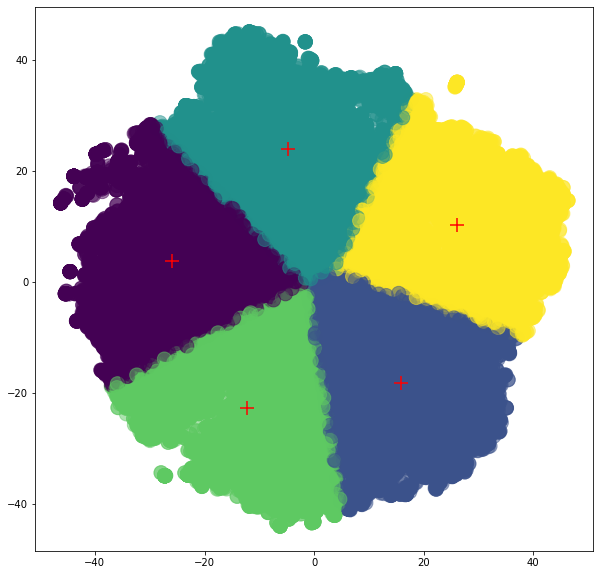

In [48]:
# Визуализация результата

print ("Коэффициент силуэта: %0.3f" % silhouette_score(transformed, y_pred, metric='euclidean'))

plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(transformed[:, 0], transformed[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

Коэффициент силуэта низок. Так же, визуально, разделение между кластерами весьма условно. Тем не менее, имеет смысл добавить данные. Полезность будет оценена позже.

In [49]:
# Добавление значений во вспомогательный DataFrame
for_processing['txt_cluster'] = y_pred+np.ones(y_pred.shape[0])
for_processing.sample(3)

,ID_TA,box_vec,txt_cluster
19571,d10746904,"[0.6332331, -0.69705415, 0.3380002, -0.6282492...",4.0
42291,d983834,"[1.0047863, 0.07376848, 1.1133391, 0.1588485, ...",1.0
34778,d969171,"[1.2017356, 0.5051598, 1.2459763, -0.40274364,...",3.0


In [50]:
# Удаление дубликатов
for_processing.drop_duplicates('ID_TA', inplace = True)

In [51]:
# Добавление кластера к основным данным
data = pd.merge(data,for_processing.drop('box_vec',axis = 1), on='ID_TA', how='outer')
data.txt_cluster.fillna(0, inplace=True)

# Длинна коментариев
data['txt_length'] = data.wordbox.apply(lambda x: len(x))

# Удаление вспомогательных признаков
data.drop(['wordbox','box_vec','help'], axis=1, inplace=True)

data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,ID_TA,train,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length
49336,id_9355,London,"[German, European]",5037.0,0.0,1.0,14.0,d12165751,0,0,2,0,2,950400.0,1.491005e+09,1.0,3
29881,id_13708,Paris,[French],13710.0,2.0,NaN,5.0,d4271982,1,0,1,1,1,0.0,1.374451e+09,5.0,6
45620,id_5633,Bratislava,NaN,841.0,0.0,NaN,2.0,d4769838,0,1,0,1,1,0.0,1.490400e+09,2.0,4


## 5. Обработка ID_TA / URL_TA

- В данных имеется ссылка на страницу для каждого ресторана. С одной стороны, актуальные рейтинги могут восприниматься как утечка данных. С другой стороны, ссылки были предоставлены и странно было бы ими не воспользоваться.

- Так как, TripAdvisor неохотно предоставляет доступ к API, ссылки были обработаны через HTML запросы к сайту. По скольку, данный процесс занимает довольно много времени, обработка была проведена вне этого ноутбука.

- Ссылка на ноутбук обработки:
https://github.com/blinnikov-ae/skillfactory_rds/blob/master/module_3/TripAdvisor_actual_rating_april_2021.ipynb

In [52]:
# Загрузка результатов обработки
actual_ratings = pd.read_csv('TA_ratings_04_2021.csv')
actual_ratings.sample(3)

,ID_TA,current_rating
1655,d1024456,4.0
40565,d5506579,5.0
47733,d12435055,5.0


In [53]:
# Проверка на дубликаты
actual_ratings.ID_TA.duplicated().sum()

0

In [54]:
# Добавление кластера к основным данным
data = pd.merge(data,actual_ratings, on='ID_TA', how='outer')
data.drop('ID_TA', axis=1, inplace=True)

# Пометка данных имеющих пропуски
data['cur_rate_nan'] = pd.isna(data['current_rating']).astype('uint8')

data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,train,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,cur_rate_nan
15381,id_4986,Barcelona,"[Cafe, Mediterranean, Spanish]",4987.0,4.5,NaN,2.0,1,0,3,1,0,0.0,0.000000e+00,0.0,0,4.5,0
3051,id_508,Oslo,"[Italian, Mediterranean, European]",509.0,4.0,2.0,29.0,1,0,3,0,2,1296000.0,1.508458e+09,3.0,10,4.0,0
37391,id_1622,Warsaw,"[Polish, International, European]",1624.0,4.0,NaN,NaN,1,0,3,1,1,0.0,1.441498e+09,3.0,3,NaN,1


## Итог
Две текстовые переменные (City, Cuisine Style) могут быть перекодированы в dummy-переменные.  Имеет смысл отдельно проверить полезность Cuisine Style, т.к. переменная очень грамоздкая. Остальные переменные в числовом формате.

In [55]:
# Разбиваем признаки по группам
cat_cols = ['City', 'Price Range','txt_cluster']
num_cols = ['Ranking', 'Number of Reviews', 'cuisine_amount', 
            'rvws_amount', 'rvws_time_span', 'rvws_latest', 
            'txt_length', 'current_rating']
bin_cols = ['cuisine_nan', 'p_range_nan', 'cur_rate_nan']

# Проверка, что вошли все колонки, кроме 'train', 'Rating', 'Cuisine Style'
len(cat_cols) + len(num_cols) + len(bin_cols) - len(data.columns) + 3

-1

# Наивная модель

In [56]:
# Функция возвращает среднюю ошибку для данных и модели
def MAE(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = RS)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return mean_absolute_error(y_test, y_pred)

In [57]:
results = {}

In [58]:
# Возьмем данные без признаков с пропусками
naive = data[data.train==1].drop(['train','Restaurant_id'],axis=1)
naive = naive.dropna(axis=1)
naive.sample(3)

,City,Ranking,Rating,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,cur_rate_nan
13130,Paris,7245.0,4.5,1,0,1,1,0.0,1.488845e+09,1.0,5,0
11710,London,9007.0,5.0,0,1,0,1,0.0,1.511482e+09,3.0,2,0
19620,Paris,10351.0,3.5,0,4,0,2,6048000.0,1.458605e+09,4.0,5,1


In [59]:
# Обработка категориальных признаков
naive = pd.get_dummies(naive, columns = ['City', 'txt_cluster'], prefix=None, dummy_na=False)

In [60]:
# Для оценки будем использовать RandomForestRegressor
results['naive'] = MAE(X=naive.drop('Rating', axis = 1), 
    y=naive.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['naive'], 2))

MAE:	 0.27


# Пропуски в данных

## 1.  Заполнение нулями

In [61]:
zeros = data[data.train==1].drop(['train','Restaurant_id'],axis=1)
zeros = zeros.fillna(0)
zeros.sample(3)

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,cur_rate_nan
15559,Rome,"[Wine, Bar]",5578.0,4.5,2.0,18.0,0,2,0,1,0.0,1.446595e+09,3.0,3,4.5,0
27635,Stockholm,"[European, Swedish, Scandinavian, Danish]",98.0,4.5,2.0,119.0,0,4,0,2,10195200.0,1.515283e+09,1.0,5,4.0,0
9701,London,"[Bar, European, British]",14908.0,3.5,2.0,210.0,0,3,0,2,777600.0,1.492992e+09,4.0,9,0.0,1


In [62]:
# Обработка признаков
zeros = pd.get_dummies(zeros, columns = cat_cols, prefix=None, dummy_na=False)
zeros.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['zeros'] = MAE(X=zeros.drop('Rating', axis = 1), 
    y=zeros.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['zeros'], 2))

MAE:	 0.18


## 2.  Заполнение медианой

In [63]:
median = data[data.train==1].drop(['train','Restaurant_id'],axis=1)
for col in ['Price Range','Number of Reviews','current_rating']:
    median[col].fillna(median[col].median(), inplace=True)
median.sample(3)

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,cur_rate_nan
31267,Berlin,"[French, German]",3438.0,5.0,1.0,33.0,0,2,0,1,0.0,1.506298e+09,3.0,2,5.0,0
9518,Berlin,[Japanese],3727.0,4.0,2.0,6.0,0,1,1,2,13478400.0,1.513987e+09,2.0,7,4.0,0
29293,Prague,"[Czech, European]",1370.0,4.5,2.0,16.0,0,2,0,2,11923200.0,1.505520e+09,4.0,4,4.5,0


In [64]:
# Обработка признаков
median = pd.get_dummies(median, columns = cat_cols, prefix=None, dummy_na=False)
median.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['median'] = MAE(X=median.drop('Rating', axis = 1), 
    y=median.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['median'], 2))

MAE:	 0.18


## 3.  Заполнение самым частым значением

In [65]:
frequent = data[data.train==1].drop(['train','Restaurant_id'],axis=1)
for col in ['Price Range','Number of Reviews','current_rating']:
    frequent[col].fillna(frequent[col].value_counts().index[0], inplace=True)
frequent.sample(3)

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,cur_rate_nan
31937,London,"[Fast, Food, Grill, Vegetarian, Friendly, Halal]",13098.0,3.5,2.0,25.0,0,6,0,2,8985600.0,1.498262e+09,2.0,6,4.0,0
4410,Berlin,NaN,3350.0,5.0,2.0,2.0,1,0,1,0,0.0,0.000000e+00,0.0,0,4.0,1
30514,Berlin,"[German, European, Central, European, Bar, Veg...",1497.0,4.0,2.0,103.0,0,7,0,2,21081600.0,1.513555e+09,2.0,14,4.0,0


In [66]:
# Обработка признаков
frequent = pd.get_dummies(frequent, columns = cat_cols, prefix=None, dummy_na=False)
frequent.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['frequent'] = MAE(X=frequent.drop('Rating', axis = 1), 
    y=frequent.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['frequent'], 2))

MAE:	 0.18


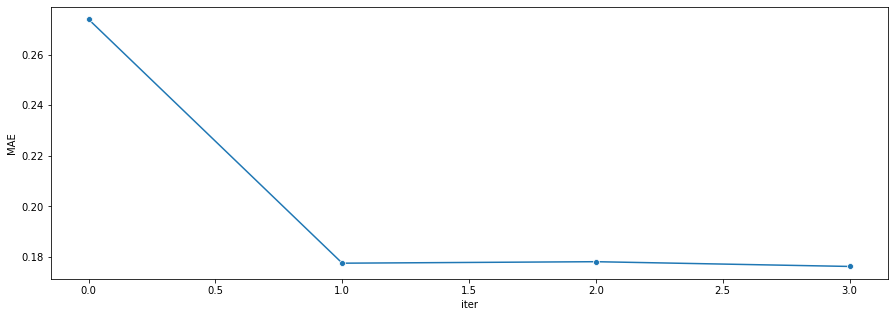

naive: 0.274
zeros: 0.1775
median: 0.1781
frequent: 0.1762


In [67]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=[x for x in range(len(results.values()))], y=list(results.values()), marker='o')
ax.set(ylabel='MAE', xlabel='iter')
plt.show()

for key, value in results.items():
    print('{}: {}'.format(key, np.round(value, 4)))

## Вывод

Заполнение медианным или самым частым значениями не дают прибавки в точности модели. Это можно объяснить тем, что '0' дополнительно помогает дереву решений отделять примеры с пропусками. В любом случае, не имеет смысл заполнять пропуски по средствам доп. моделирования и можно ограничиться заполнением нулями.

In [68]:
data = data.fillna(0)
data.sample(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,train,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,cur_rate_nan
14594,id_413,London,"[Cafe, British, Diner, Vegetarian, Friendly, V...",414.0,4.5,1.0,216.0,1,0,10,0,2,432000.0,1.515370e+09,5.0,8,4.5,0
19386,id_15804,London,"[Italian, Mediterranean, Cafe]",15816.0,4.5,1.0,9.0,1,0,3,0,2,259200.0,1.478909e+09,1.0,10,0.0,1
27296,id_845,Warsaw,"[European, Polish, Mediterranean]",846.0,4.0,2.0,20.0,1,0,3,0,2,25401600.0,1.493770e+09,4.0,10,4.5,0


# EDA

## Бинарные данные

In [69]:
#Функция, проверяющая наличае статистически значимых различий между вариациями признака
def get_stat_dif(df, col, target):
    variations=len(df[col].value_counts().index)
    indexes=[i for i in range (0,variations)]
    comb=list(combinations(indexes, 2))
    for c in comb:
        x = df[df[col] == df[col].value_counts().index[c[0]]][target]
        y = df[df[col] == df[col].value_counts().index[c[1]]][target]
        t_test = weightstats.ttest_ind(x, y, usevar='unequal')
        if t_test[1] <= 0.05/len(comb):
            return True
        else:
            return False

In [70]:
# Функция выводит основную информацию и график признака
def sum_up_cat(df, col, target):
    print(col.upper())
    vc = df[col].value_counts()
    vc_p = df[col].value_counts(normalize=True)
    for i in vc.index:
        print('{} (%%):\t{}'.format(i, np.round(vc_p[i],2)))
        print('\t Среднее значение целевой:\t{}'.format(np.round(df[df[col] == i][target].mean(),2)))
    print('Cтатистически значимые различия:\t{}'.format(get_stat_dif(df, col, target)))
    plt.figure()
    sns.catplot(data = df,  x = col, kind = 'count', palette = 'viridis')
    plt.show()

CUISINE_NAN
0 (%%):	0.77
	 Среднее значение целевой:	4.01
1 (%%):	0.23
	 Среднее значение целевой:	3.95
Cтатистически значимые различия:	True


<Figure size 720x720 with 0 Axes>

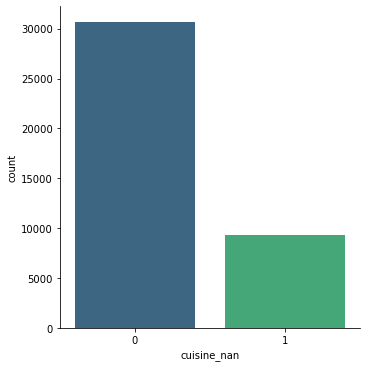

P_RANGE_NAN
0 (%%):	0.65
	 Среднее значение целевой:	4.02
1 (%%):	0.35
	 Среднее значение целевой:	3.93
Cтатистически значимые различия:	True


<Figure size 720x720 with 0 Axes>

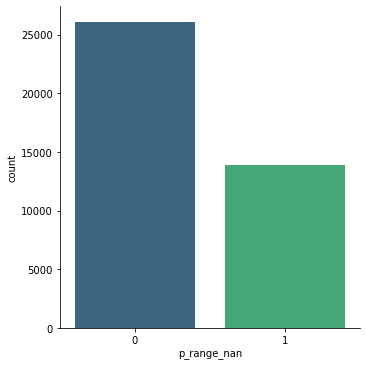

CUR_RATE_NAN
0 (%%):	0.88
	 Среднее значение целевой:	3.99
1 (%%):	0.12
	 Среднее значение целевой:	4.0
Cтатистически значимые различия:	False


<Figure size 720x720 with 0 Axes>

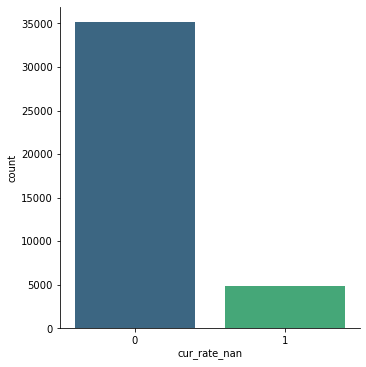

In [71]:
for column in bin_cols:
    sum_up_cat(data[data.train==1], column, 'Rating')

Бинарные признаки отражают пропущенные значения. Признак CUR_RATE_NAN не несет ценности, т.к. статистически значимые различия. Возможно, его стоит удалить.

In [72]:
drop_CRN = data[data.train==1].drop(['train', 'Restaurant_id', 'cur_rate_nan'],axis=1)

# Обработка признаков
drop_CRN = pd.get_dummies(drop_CRN, columns = cat_cols, prefix=None, dummy_na=False)
drop_CRN.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['drop_CRN'] = MAE(X=drop_CRN.drop('Rating', axis = 1), 
    y=drop_CRN.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['drop_CRN'], 2))

MAE:	 0.18


In [73]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936}

In [74]:
data.drop('cur_rate_nan', axis=1, inplace=True)
bin_cols.remove('cur_rate_nan')

## Категориальные данные

CITY
London (%%):	0.14
	 Среднее значение целевой:	3.96
Paris (%%):	0.12
	 Среднее значение целевой:	3.94
Madrid (%%):	0.08
	 Среднее значение целевой:	3.8
Barcelona (%%):	0.07
	 Среднее значение целевой:	3.96
Berlin (%%):	0.05
	 Среднее значение целевой:	4.12
Milan (%%):	0.05
	 Среднее значение целевой:	3.82
Rome (%%):	0.05
	 Среднее значение целевой:	4.23
Prague (%%):	0.04
	 Среднее значение целевой:	4.03
Lisbon (%%):	0.03
	 Среднее значение целевой:	4.05
Vienna (%%):	0.03
	 Среднее значение целевой:	4.08
Amsterdam (%%):	0.03
	 Среднее значение целевой:	4.13
Brussels (%%):	0.03
	 Среднее значение целевой:	3.91
Hamburg (%%):	0.02
	 Среднее значение целевой:	4.02
Munich (%%):	0.02
	 Среднее значение целевой:	4.05
Lyon (%%):	0.02
	 Среднее значение целевой:	3.95
Stockholm (%%):	0.02
	 Среднее значение целевой:	3.87
Budapest (%%):	0.02
	 Среднее значение целевой:	4.09
Warsaw (%%):	0.02
	 Среднее значение целевой:	4.09
Dublin (%%):	0.02
	 Среднее значение целевой:	4.06
Copenhagen (%%):	0.

<Figure size 720x720 with 0 Axes>

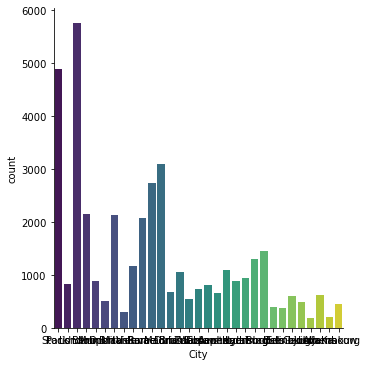

PRICE RANGE
2.0 (%%):	0.46
	 Среднее значение целевой:	3.99
0.0 (%%):	0.35
	 Среднее значение целевой:	3.93
1.0 (%%):	0.16
	 Среднее значение целевой:	4.09
3.0 (%%):	0.04
	 Среднее значение целевой:	4.2
Cтатистически значимые различия:	True


<Figure size 720x720 with 0 Axes>

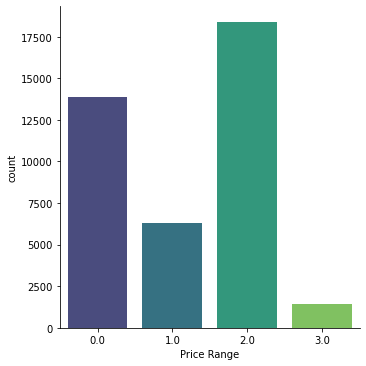

TXT_CLUSTER
3.0 (%%):	0.17
	 Среднее значение целевой:	4.11
5.0 (%%):	0.17
	 Среднее значение целевой:	4.1
2.0 (%%):	0.17
	 Среднее значение целевой:	3.83
1.0 (%%):	0.17
	 Среднее значение целевой:	4.14
0.0 (%%):	0.16
	 Среднее значение целевой:	3.96
4.0 (%%):	0.16
	 Среднее значение целевой:	3.8
Cтатистически значимые различия:	False


<Figure size 720x720 with 0 Axes>

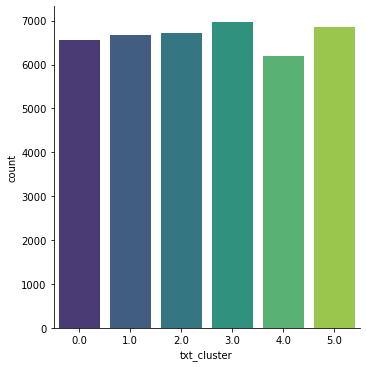

In [75]:
for column in cat_cols:
    sum_up_cat(data[data.train==1], column, 'Rating')

Не смотря на низкий коэффициент силуэта, TXT_CLUSTER представляет ценность. Средний рейтинг ниже для кластеров 2нх из 5. Для CITY статистически значимые различия не найдены. Признак может пригодиться для извлечения доп. данных. Тем не менее, стоит протестировать модель без него.

In [76]:
drop_city = data[data.train==1].drop(['train', 'Restaurant_id', 'City'],axis=1)

# Обработка признаков
drop_city = pd.get_dummies(drop_city, columns = ['Price Range','txt_cluster'], prefix=None, dummy_na=False)
drop_city.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['drop_city'] = MAE(X=drop_city.drop('Rating', axis = 1), 
    y=drop_city.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['drop_city'], 2))

MAE:	 0.21


In [77]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604}

## Числовые данные

In [78]:
# Функция расчитывает кол-во выбросов по столбцам и их долю
def outbursts(df, col):
    Q25 = df[col].quantile(0.25)
    Q75 = df[col].quantile(0.75)
    IQR = Q75 - Q25
    lowest = Q25 - 1.5*IQR
    highest = Q75 + 1.5*IQR
    amount = df[(df[col] < lowest)|(df[col] > highest)].count()[0]
    ratio = amount/df.shape[0]
    return amount, ratio, lowest, highest

In [79]:
#Функция выводит основную информацию и график признака
def sum_up_num(df, col, target):
    print(col.upper())
    print(df[col].describe()[1:])
    print('Кол-во выбросов: {} \t (%%: {})'.format(outbursts(df, col)[0], 
                                                   np.round(outbursts(df, col)[1]*100,2)))
    print()
    fig, axs = plt.subplots(figsize=(15, 5), ncols=2)
    sns.distplot(df[col], kde=True, ax=axs[0])
    sns.boxplot(data = df,  x = col, palette = 'viridis', ax=axs[1])
    plt.show()

RANKING
mean     3676.497249
std      3709.500590
min         1.000000
25%       973.000000
50%      2284.000000
75%      5261.000000
max     16444.000000
Name: Ranking, dtype: float64
Кол-во выбросов: 2447 	 (%%: 6.12)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


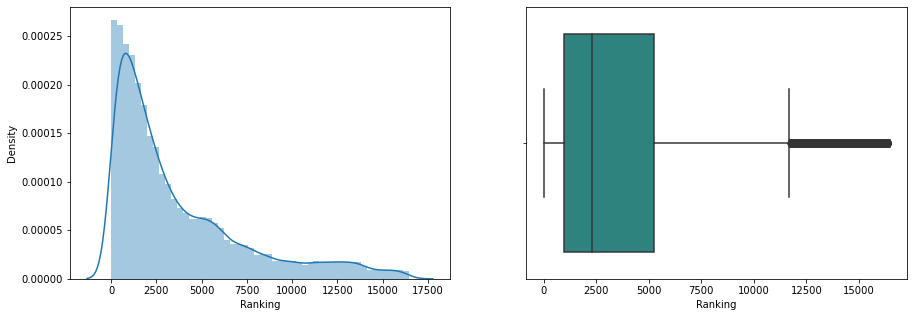

NUMBER OF REVIEWS
mean     116.890145
std      287.785867
min        0.000000
25%        7.000000
50%       28.000000
75%      104.250000
max     9660.000000
Name: Number of Reviews, dtype: float64
Кол-во выбросов: 4790 	 (%%: 11.98)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


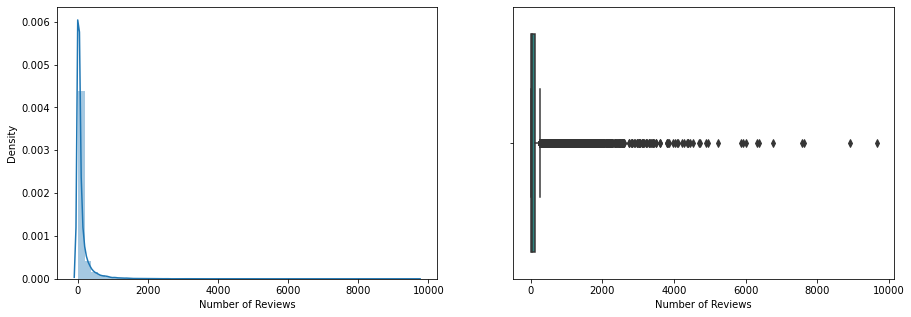

CUISINE_AMOUNT
mean     3.141396
std      3.097334
min      0.000000
25%      1.000000
50%      2.000000
75%      5.000000
max     27.000000
Name: cuisine_amount, dtype: float64
Кол-во выбросов: 468 	 (%%: 1.17)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


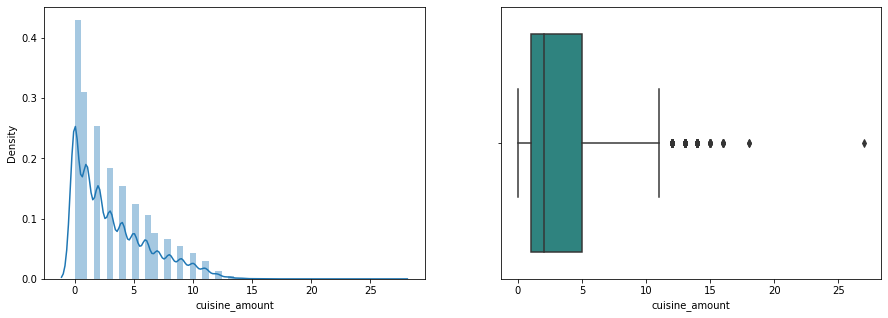

RVWS_AMOUNT
mean    1.562731
std     0.754712
min     0.000000
25%     1.000000
50%     2.000000
75%     2.000000
max     3.000000
Name: rvws_amount, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


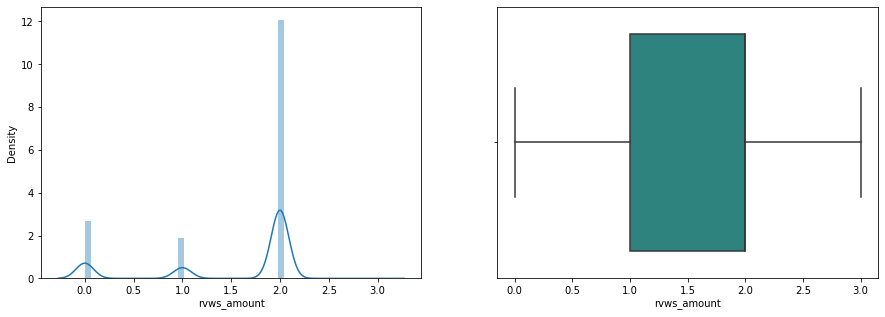

RVWS_TIME_SPAN
mean    8.868474e+06
std     1.716046e+07
min     0.000000e+00
25%     0.000000e+00
50%     2.419200e+06
75%     1.036800e+07
max     2.770848e+08
Name: rvws_time_span, dtype: float64
Кол-во выбросов: 3579 	 (%%: 8.95)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


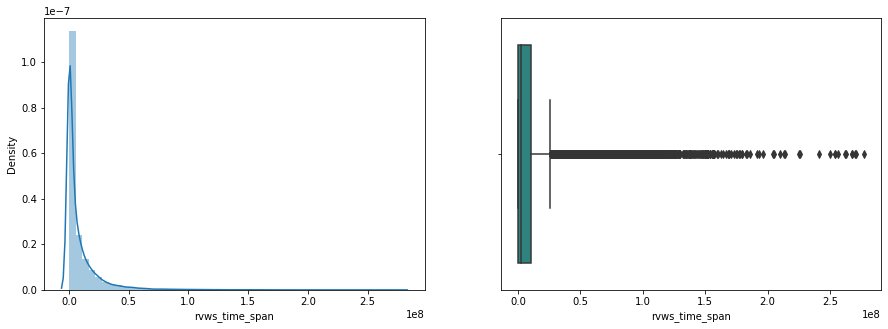

RVWS_LATEST
mean    1.252913e+09
std     5.510430e+08
min     0.000000e+00
25%     1.461629e+09
50%     1.502064e+09
75%     1.511741e+09
max     1.519603e+09
Name: rvws_latest, dtype: float64
Кол-во выбросов: 7029 	 (%%: 17.58)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


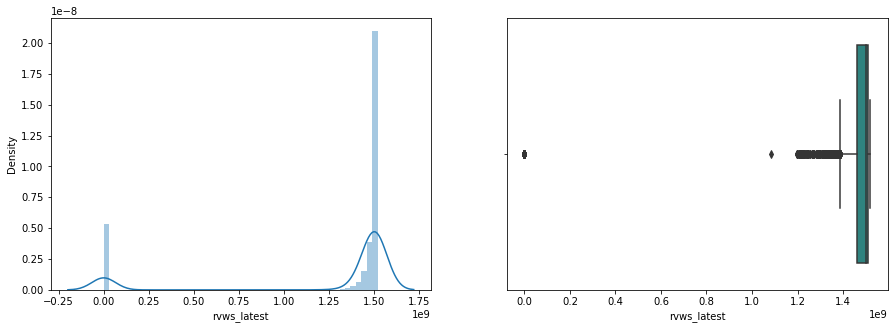

TXT_LENGTH
mean     6.036468
std      3.773797
min      0.000000
25%      4.000000
50%      6.000000
75%      9.000000
max     18.000000
Name: txt_length, dtype: float64
Кол-во выбросов: 30 	 (%%: 0.08)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


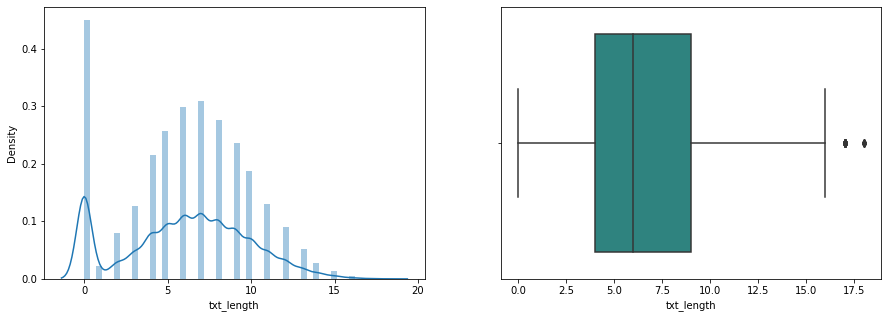

CURRENT_RATING
mean    3.472424
std     1.421111
min     0.000000
25%     3.500000
50%     4.000000
75%     4.500000
max     5.000000
Name: current_rating, dtype: float64
Кол-во выбросов: 5074 	 (%%: 12.69)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


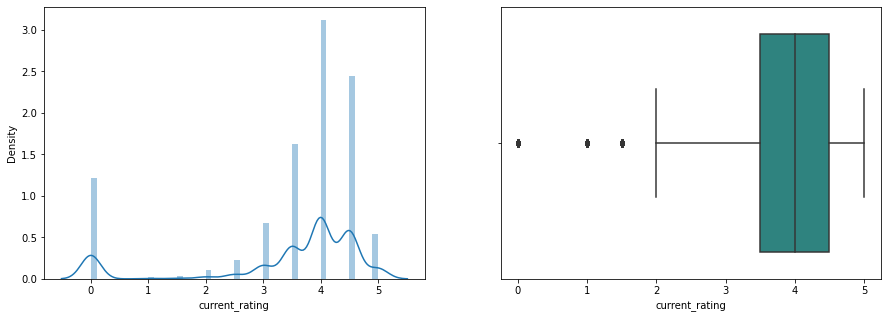

In [80]:
for column in num_cols:
    sum_up_num(data[data.train==1], column, 'Rating')

<AxesSubplot:>

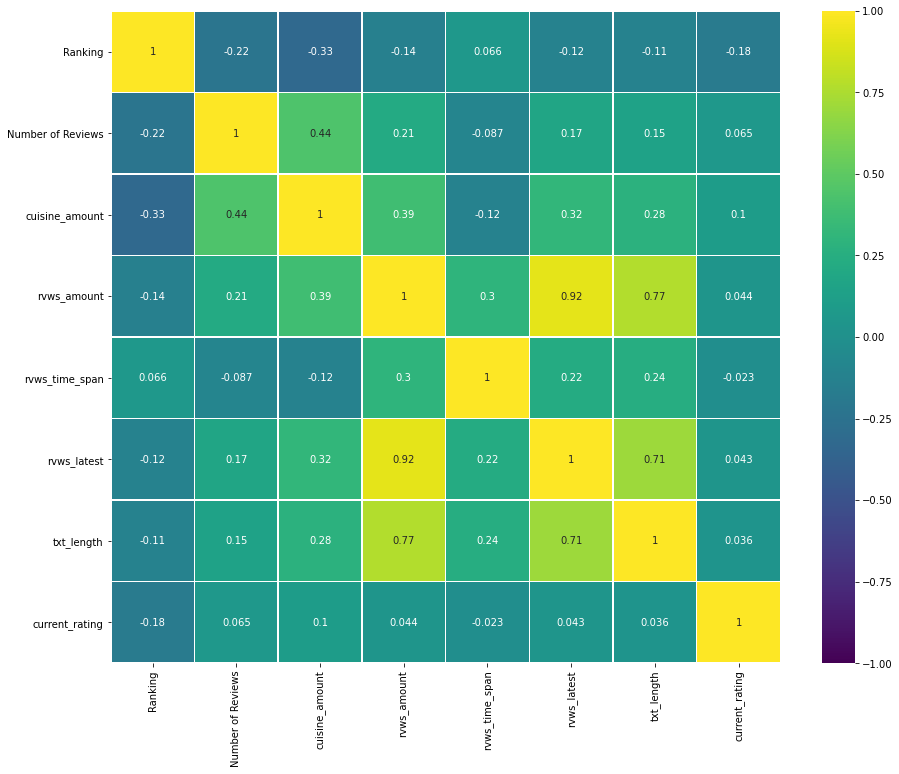

In [81]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data[data.train==1][num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

Для числовых признаков, имеется довольно много выбросов. Тем не менее, выбросы не выглядят аномальными. Среди признаков, извлеченных из Reviews, наблюдается высокая корреляция. Может иметь смысл избавиться от rvws_latest, как признака для которого выбросы наиболее велики.

Так же, необходимо отдельно рассмотреть Ranking, т.к. признак отражает ранг в конкретном городе.

In [82]:
drop_RL = data[data.train==1].drop(['train','Restaurant_id', 'rvws_latest'],axis=1)

# Обработка признаков
drop_RL = pd.get_dummies(drop_RL, columns = cat_cols, prefix=None, dummy_na=False)
drop_RL.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['drop_RL'] = MAE(X=drop_RL.drop('Rating', axis = 1), 
    y=drop_RL.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['drop_RL'], 2))

MAE:	 0.18


In [83]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604,
 'drop_RL': 0.1772404952476238}

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

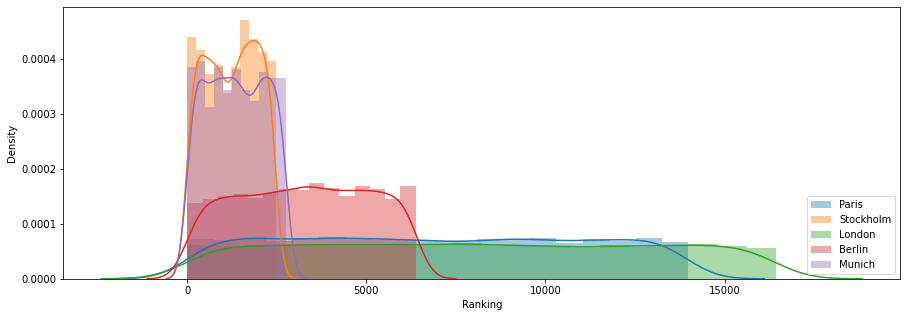

In [84]:
plt.figure(figsize=(15, 5))
for city in data.City.unique()[:5]:
    sns.distplot(data[data.City==city]['Ranking'], kde=True, label=city)
plt.legend(loc='lower right')
plt.show()

Без rvws_latest, MAE чуть выше. Имеет смысл стандартизировать Ranking, относительно города. Стандартизация будет выполнена позже, при извлечении доп. информации из City.

In [85]:
# Создание словаря с максимальным значением Ranking для города
city_max = {}
for city in list(data.City.unique()):
    city_max[city] = data[data.City == city].Ranking.max()

In [86]:
# Функция возражает произведение значений Ranking и максисального значения Ranking по городу
def std_rank(row):
    return row.Ranking/city_max[row.City]

CITY_RANKING
mean    0.498804
std     0.287685
min     0.000061
25%     0.249571
50%     0.497555
75%     0.747571
max     1.000000
Name: city_ranking, dtype: float64
Кол-во выбросов: 0 	 (%%: 0.0)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


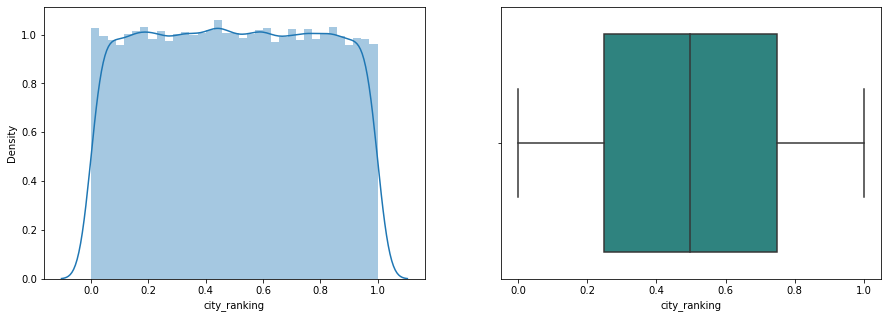

In [87]:
# Параметр ranking_norm стандартизированный Ranking
data['city_ranking'] = data.apply(std_rank, axis = 1)
num_cols.append('city_ranking')
sum_up_num(data[data.train==1], 'city_ranking', 'Rating')

<AxesSubplot:>

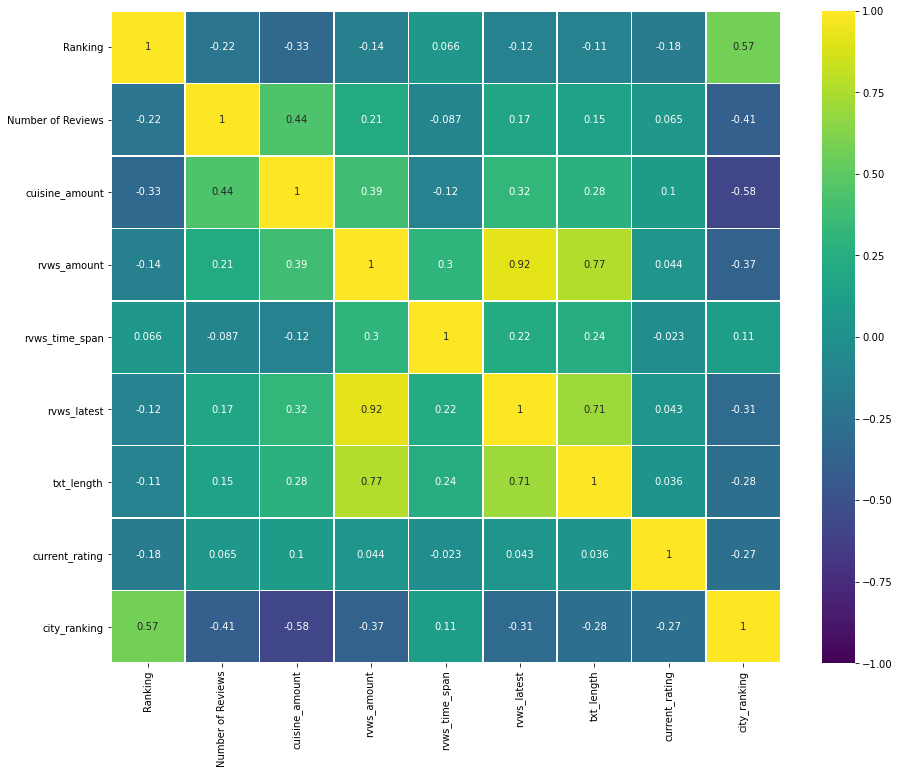

In [88]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data[data.train==1][num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

In [89]:
city_r = data[data.train==1].drop(['train','Restaurant_id'],axis=1)

# Обработка признаков
city_r = pd.get_dummies(city_r, columns = cat_cols, prefix=None, dummy_na=False)
city_r.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['city_r'] = MAE(X=city_r.drop('Rating', axis = 1), 
    y=city_r.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['city_r'], 2))

MAE:	 0.15


In [90]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604,
 'drop_RL': 0.1772404952476238,
 'city_r': 0.15290332666333165}

## Cuisine Style

In [91]:
# Функция возвращает 'Non_specified' для пустых занчений Cuisine Style
def filling_CS_nan(cuisine_style):
    if type(cuisine_style) == int:
        return ['Non_specified']
    else:
        return cuisine_style

In [92]:
data['Cuisine Style'] = data['Cuisine Style'].apply(filling_CS_nan)

In [93]:
data.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,train,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,city_ranking
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2.0,194.0,1,0,3,0,2,3542400.0,1.514678e+09,2.0,8,3.5,0.398255
1,id_1535,Stockholm,[Non_specified],1537.0,4.0,0.0,10.0,1,1,0,1,2,33004800.0,1.499299e+09,1.0,5,4.0,0.623782
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian, Fr...",353.0,4.5,3.0,688.0,1,0,11,0,2,172800.0,1.515370e+09,2.0,6,4.5,0.021467


In [94]:
# Функция для заполнения категории Cuisine Style
def dummy_cuisine(cell):
    if item in cell:
        return 1
    return 0

In [95]:
# Список уникальных значений Cuisine Style
all_cuisines = pd.Series(data['Cuisine Style'].sum()).unique()

In [96]:
dummy_cs = data[data.train==1].drop(['train','Restaurant_id'],axis=1)

# Кодирование Cuisine Style
for item in all_cuisines:
    dummy_cs[item] = dummy_cs['Cuisine Style'].apply(dummy_cuisine)

# Обработка признаков
dummy_cs = pd.get_dummies(dummy_cs, columns = cat_cols, prefix=None, dummy_na=False)
dummy_cs.drop('Cuisine Style', axis=1, inplace=True)

# Расчет метрики
results['dummy_cs'] = MAE(X=dummy_cs.drop('Rating', axis = 1), 
    y=dummy_cs.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['dummy_cs'], 2))

MAE:	 0.15


In [97]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604,
 'drop_RL': 0.1772404952476238,
 'city_r': 0.15290332666333165,
 'dummy_cs': 0.15336918459229615}

Добавление признака Cuisine Style дает лишь несущественное понижение MAE. Можно удалить признак.

In [98]:
data.drop('Cuisine Style', axis=1, inplace=True)

## Вывод

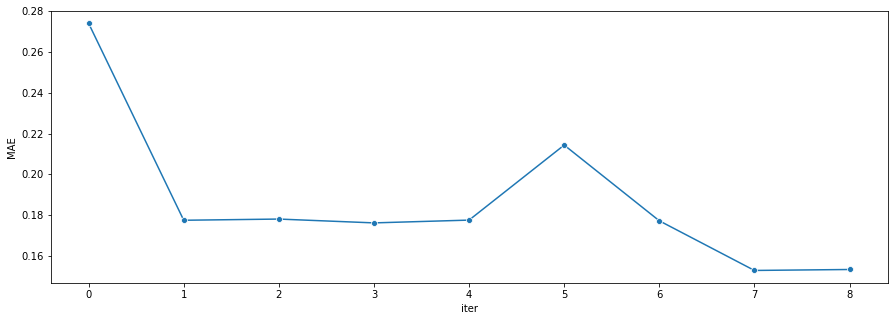

naive: 0.274
zeros: 0.1775
median: 0.1781
frequent: 0.1762
drop_CRN: 0.1776
drop_city: 0.2143
drop_RL: 0.1772
city_r: 0.1529
dummy_cs: 0.1534


In [99]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=[x for x in range(len(results.values()))], y=list(results.values()), marker='o')
ax.set(ylabel='MAE', xlabel='iter')
plt.show()

for key, value in results.items():
    print('{}: {}'.format(key, np.round(value, 4)))

В ходе анализа данных удалось выявить неинформативный признак. Cтандартизированный Ranking существенно улучшил модель. Cuisine Style был уален.

# Feature Engineering

In [100]:
# Функция измеряет взаимную информацию для ряда переменных
def mi_reg(features, target):
    mi_scores = mutual_info_regression(features, target, random_state = RS)
    mi_scores = pd.Series(mi_scores, index=features.columns)
    return mi_scores

<AxesSubplot:>

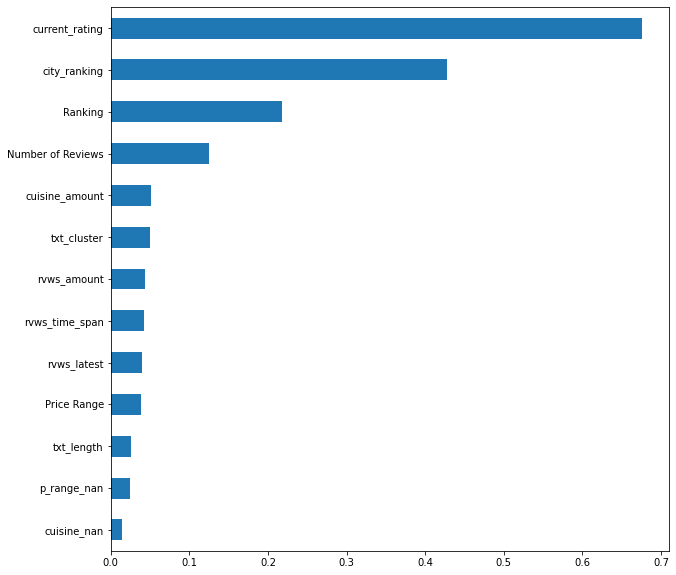

In [101]:
# Расчет взаимной иформации
train = data[data.train==1].drop(['train', 'Restaurant_id', 'City'],axis=1)
features = train.drop('Rating', axis = 1)
target = train.Rating
mi_scores = mi_reg(features, target)
mi_scores = mi_scores.sort_values()
mi_scores.plot(kind = 'barh')

Наиболее информативными признаками являются, созданные при обработке, current_rating, city_ranking. Возможно, имеет смысл дополнительно кластеризировать данные на основе данных признаков.

Извлечение данных из Cuisine Style, Reviews и обозначение пропусков не дают ощутимой прибавки в полезной информации. Тем не менее, можно попробовать дополнительно извлечь информацию по городу.

## 1. Clustering

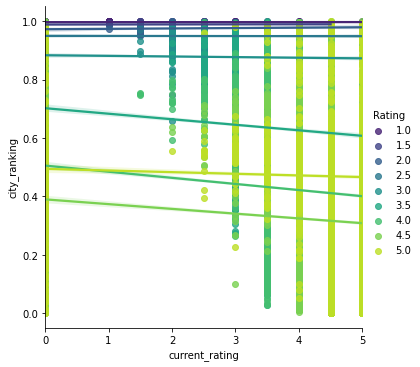

In [102]:
# Визуализация отношения city_ranking и current_rating с учетом целевой Rating
sns.lmplot(data=data[data.train==1], 
                x='current_rating', y='city_ranking',
                hue='Rating', palette='viridis')

Коэффициент силуэта: 0.480


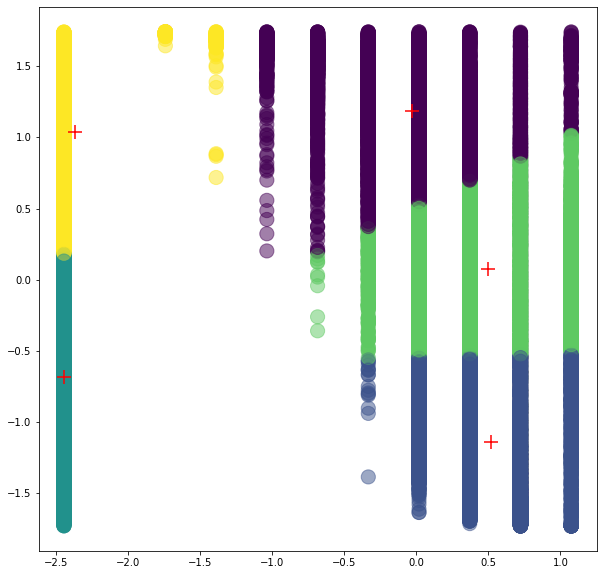

In [103]:
# Кластеризация
x = StandardScaler().fit_transform(data[['current_rating','city_ranking']].values)
kmeans.fit(x)
y_pred = kmeans.labels_.astype(np.int)

print ("Коэффициент силуэта: %0.3f" % silhouette_score(x, y_pred, metric='euclidean'))

plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(x[:, 0], x[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

In [104]:
data['rate_rank_cluster'] = y_pred
cat_cols.append('rate_rank_cluster')

In [105]:
rr_cluster = data[data.train==1].drop(['train','Restaurant_id'],axis=1)

# Обработка признаков
rr_cluster = pd.get_dummies(rr_cluster, columns = cat_cols, prefix=None, dummy_na=False)

# Расчет метрики
results['rr_cluster'] = MAE(X=rr_cluster.drop('Rating', axis = 1), 
    y=rr_cluster.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['rr_cluster'], 2))

MAE:	 0.15


In [106]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604,
 'drop_RL': 0.1772404952476238,
 'city_r': 0.15290332666333165,
 'dummy_cs': 0.15336918459229615,
 'rr_cluster': 0.15283454227113552}

Кластеризация ухудшила модель.

In [107]:
data.drop('rate_rank_cluster', axis=1, inplace=True)
cat_cols.remove('rate_rank_cluster')

## 2. Доп. информация из City

In [108]:
# Загрузка справочника городов
cities_stat = pd.read_csv('worldcities.csv')
cities_stat.sample(3)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
24743,Neubulach,Neubulach,48.6611,8.6967,Germany,DE,DEU,Baden-Württemberg,NaN,5624.0,1276878113
7430,Ecublens,Ecublens,46.5276,6.5605,Switzerland,CH,CHE,Vaud,NaN,12854.0,1756001755
21005,St. Marys,St. Marys,40.5475,-84.3931,United States,US,USA,Ohio,NaN,9180.0,1840009408


In [109]:
# Проверка есть ли все города в справочнике.
# В случае нескольких городов, взят самый крупный
for city in data.City.unique():
    cities = cities_stat[cities_stat.city_ascii == city]
    if cities.shape[0] == 0:
        print('"{}" отсутствует в cities_stat'.format(city))

"Oporto" отсутствует в cities_stat


Oporto одно из двух названий португальского Porto.

In [110]:
# Преобразование Oporto в Porto
data['City'] = data['City'].apply(lambda x: 'Porto' if x=='Oporto' else x)

In [111]:
# Выбираем из справочника только необходимое
city_ids = []
for city in data.City.unique():
    cities = cities_stat[cities_stat.city_ascii == city]
    city_id = cities[cities.population == cities.population.max()].index[0]
    city_ids.append(city_id)


useful_stat = cities_stat.loc[city_ids][['city_ascii','lat','lng','country','population']]
useful_stat.rename(columns = {'city_ascii': 'City'}, inplace = True)
useful_stat.sample(3)

,City,lat,lng,country,population
498,Munich,48.1372,11.5755,Germany,1471508.0
408,Vienna,48.2083,16.3731,Austria,1840573.0
422,Warsaw,52.2167,21.0333,Poland,1790658.0


In [112]:
# Добавление данных
data = pd.merge(data,useful_stat, on='City', how='outer')
data.sample(3)

,Restaurant_id,City,Ranking,Rating,Price Range,Number of Reviews,train,cuisine_nan,cuisine_amount,p_range_nan,...,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,city_ranking,lat,lng,country,population
45040,id_3427,Prague,3434.0,3.5,0.0,2.0,1,0,2,1,...,0.0,0.000000e+00,0.0,0,3.5,0.819962,50.0833,14.4167,Czechia,1324277.0
7636,id_15447,London,15459.0,3.5,1.0,5.0,1,0,2,0,...,3888000.0,1.511741e+09,5.0,5,0.0,0.940100,51.5072,-0.1275,United Kingdom,10979000.0
19970,id_4779,Milan,4782.0,3.5,2.0,1496.0,1,0,12,0,...,5184000.0,1.506384e+09,2.0,9,3.0,0.762072,45.4669,9.1900,Italy,1351562.0


### 2.1. Country

In [113]:
cat_cols.append('country')

In [114]:
country = data[data.train==1].drop(['train','Restaurant_id'],axis=1)

# Обработка признаков
country = pd.get_dummies(country, columns = cat_cols, prefix=None, dummy_na=False)
country.drop(['lat','lng','population'],axis=1)

# Расчет метрики
results['country'] = MAE(X=country.drop('Rating', axis = 1), 
    y=country.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['country'], 2))

MAE:	 0.15


In [115]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604,
 'drop_RL': 0.1772404952476238,
 'city_r': 0.15290332666333165,
 'dummy_cs': 0.15336918459229615,
 'rr_cluster': 0.15283454227113552,
 'country': 0.15018259129564782}

Признак улучшает результат модели

### 2.2. Координаты

Без использования платного Google API.

Карта выгружена с https://www.openstreetmap.org/ по координатам и добавлена как PNG-файл.

In [116]:
# Границы координат
coor_box = ((data.lng.min(), data.lng.max(), 
             data.lat.min(), data.lat.max()))
coor_box

(-9.1604, 24.9342, 37.9794, 60.1756)

In [117]:
# Загрузка изображения карты
ta_map = plt.imread('tripadvisor_map.png')

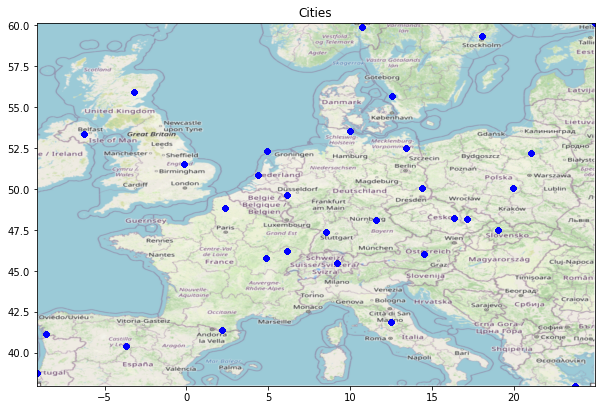

In [118]:
# Визуализация
fig, ax = plt.subplots(figsize = (10,15))
ax.scatter(data.lng, data.lat, zorder=1, alpha= 1, c='b', s=20)
ax.set_title('Cities')
ax.set_xlim(coor_box[0],coor_box[1])
ax.set_ylim(coor_box[2],coor_box[3])
ax.imshow(ta_map, zorder=0, extent = coor_box, aspect= 'equal')

Коэффициент силуэта: 0.552


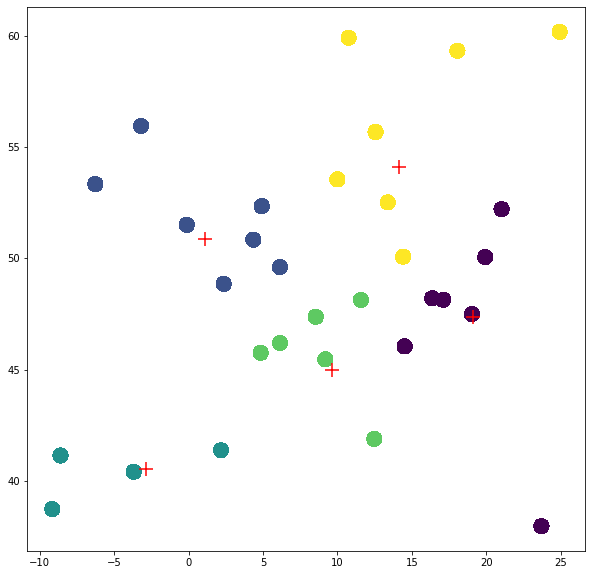

In [119]:
# Кластеризация
x = data[['lng','lat']].values
kmeans.fit(x)
y_pred = kmeans.labels_.astype(np.int)

print ("Коэффициент силуэта: %0.3f" % silhouette_score(x, y_pred, metric='euclidean'))

plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(x[:, 0], x[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
ax.set_xlim(coor_box[0],coor_box[1])
ax.set_ylim(coor_box[2],coor_box[3])
ax.imshow(ta_map, zorder=0, extent = coor_box, aspect= 'equal')
plt.show()

In [120]:
# Добаление к основным данным
data['geo_cluster'] = y_pred
data.drop(['lat','lng'], axis=1, inplace=True)
cat_cols.append('geo_cluster')

In [121]:
g_cluster = data[data.train==1].drop(['train','Restaurant_id'],axis=1)

# Обработка признаков
g_cluster = pd.get_dummies(g_cluster, columns = cat_cols, prefix=None, dummy_na=False)
g_cluster.drop(['population'],axis=1)

# Расчет метрики
results['g_cluster'] = MAE(X=g_cluster.drop('Rating', axis = 1), 
    y=g_cluster.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['g_cluster'], 2))

MAE:	 0.15


In [122]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604,
 'drop_RL': 0.1772404952476238,
 'city_r': 0.15290332666333165,
 'dummy_cs': 0.15336918459229615,
 'rr_cluster': 0.15283454227113552,
 'country': 0.15018259129564782,
 'g_cluster': 0.15032578789394693}

Кластериция на регионы Европы не дает прибавки в точности модели. Признак может быть удален.

In [123]:
data.drop('geo_cluster', axis=1, inplace=True)
cat_cols.remove('geo_cluster')

### 2.3. Population

Признак на основе населения образован путем деления на ретинг внутри города. Таким образом переменная выше для рестораннов из больших городов с высоким рейтингом. Чтобы распределение выглядело информативно, данные логорифмированы.

In [124]:
data['pop2rank'] = np.log(data['population']/data['Ranking'])
num_cols.append('pop2rank')
data.sample(3)

,Restaurant_id,City,Ranking,Rating,Price Range,Number of Reviews,train,cuisine_nan,cuisine_amount,p_range_nan,rvws_amount,rvws_time_span,rvws_latest,txt_cluster,txt_length,current_rating,city_ranking,country,population,pop2rank
34499,id_2810,Brussels,2811.0,3.0,0.0,33.0,1,1,0,1,2,31622400.0,1.506989e+09,1.0,7,3.0,0.935130,Belgium,185103.0,4.187372
45502,id_200,Prague,2008.0,0.0,0.0,0.0,0,0,2,1,0,0.0,0.000000e+00,0.0,0,5.0,0.479465,Czechia,1324277.0,6.491483
48079,id_2871,Geneva,433.0,0.0,3.0,80.0,0,0,5,0,2,26784000.0,1.515110e+09,2.0,6,4.0,0.306440,Switzerland,201818.0,6.144384


POP2RANK
mean     7.091479
std      1.158466
min      4.120968
25%      6.444567
50%      6.915398
75%      7.607669
max     16.211495
Name: pop2rank, dtype: float64
Кол-во выбросов: 2253 	 (%%: 5.64)



/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


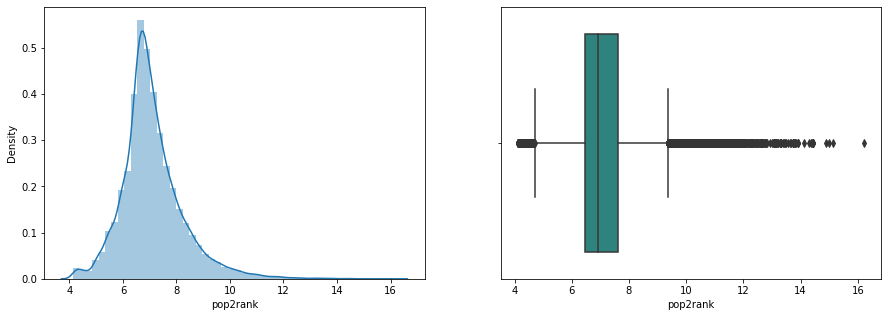

In [125]:
sum_up_num(data[data.train==1], 'pop2rank', 'Rating')

<AxesSubplot:>

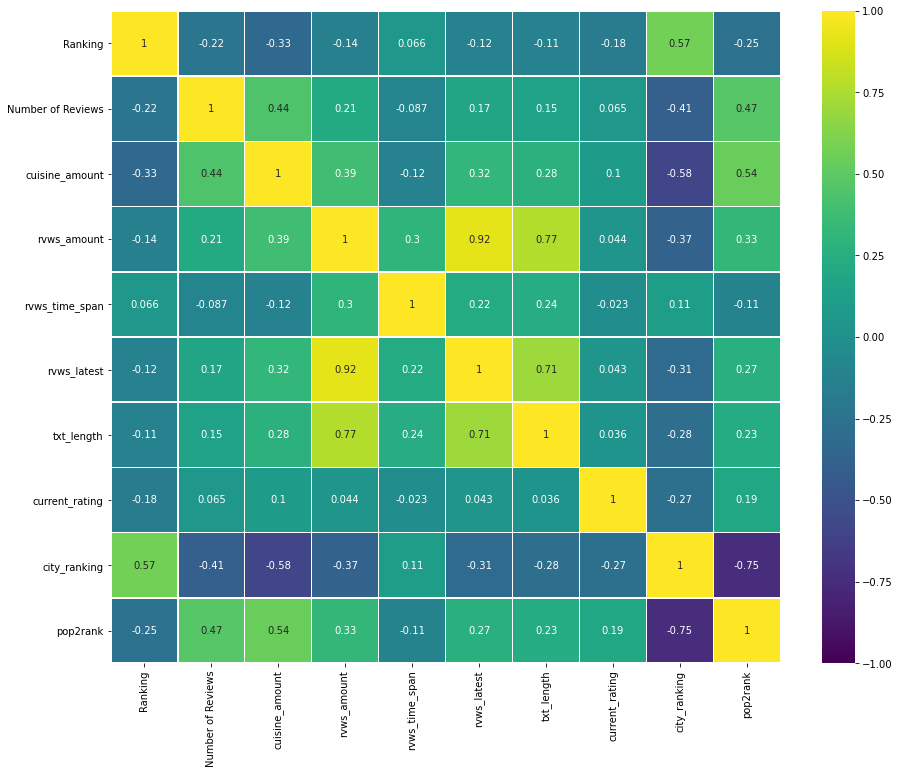

In [126]:
# Корреляционная матрица
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data[data.train==1][num_cols].corr(), vmin=-1, vmax=1, annot=True, linewidths=.5, cmap='viridis')

In [127]:
pop2rank = data[data.train==1].drop(['train','Restaurant_id'],axis=1)

# Обработка признаков
pop2rank = pd.get_dummies(pop2rank, columns = cat_cols, prefix=None, dummy_na=False)

# Расчет метрики
results['pop2rank'] = MAE(X=pop2rank.drop('Rating', axis = 1), 
    y=pop2rank.Rating, model=RandomForestRegressor(random_state=RS))
print('MAE:\t',np.round(results['pop2rank'], 2))

MAE:	 0.15


In [128]:
results

{'naive': 0.2740032516258129,
 'zeros': 0.17749874937468735,
 'median': 0.17808716858429213,
 'frequent': 0.17620935467733864,
 'drop_CRN': 0.17757503751875936,
 'drop_city': 0.21434694430548604,
 'drop_RL': 0.1772404952476238,
 'city_r': 0.15290332666333165,
 'dummy_cs': 0.15336918459229615,
 'rr_cluster': 0.15283454227113552,
 'country': 0.15018259129564782,
 'g_cluster': 0.15032578789394693,
 'pop2rank': 0.15018134067033515}

Переменая не улучшила результат и подлежит удалению.

In [129]:
data.drop('pop2rank', axis=1, inplace=True)
num_cols.remove('pop2rank')

## Вывод

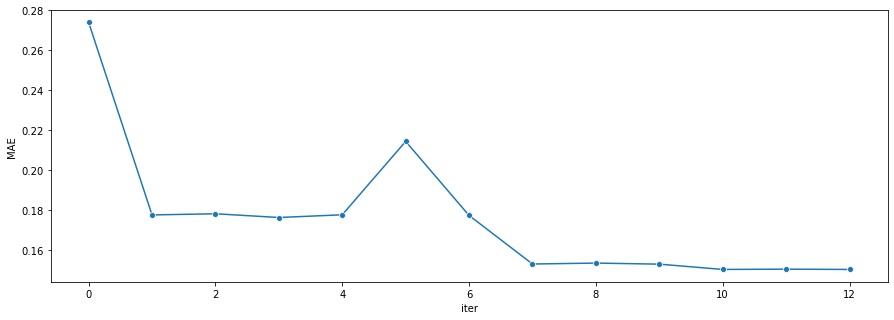

naive: 0.274
zeros: 0.1775
median: 0.1781
frequent: 0.1762
drop_CRN: 0.1776
drop_city: 0.2143
drop_RL: 0.1772
city_r: 0.1529
dummy_cs: 0.1534
rr_cluster: 0.1528
country: 0.1502
g_cluster: 0.1503
pop2rank: 0.1502


In [130]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=[x for x in range(len(results.values()))], y=list(results.values()), marker='o')
ax.set(ylabel='MAE', xlabel='iter')
plt.show()

for key, value in results.items():
    print('{}: {}'.format(key, np.round(value, 4)))

Из 4 протестированных переменных, только страна ресторана улучшила MAE.

# Model

Будут протестированы два ансабля моделей:
- Для случайного леса будут подобраны оптимальные параметры.
- Альтернативой будет градиентный бустинг.

GridSearch для ансаблей требует больших ресурсов. По этой причине, подбор оптиальных параметров производился вручную в отдельном ноутбуке без кросс-валидации.

Ссылка на ноутбук: https://github.com/blinnikov-ae/skillfactory_rds/blob/master/module_3/TripAdvisor_model_selection.ipynb

In [131]:
# Обработка признаков
data = pd.get_dummies(data, columns = cat_cols, prefix=None, dummy_na=False)

model_selection = data[data.train==1].drop(['train','Restaurant_id'],axis=1)

# Разбиение выборки
X = model_selection.drop('Rating', axis = 1)
y = model_selection.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = RS)

In [132]:
RF = RandomForestRegressor(random_state=RS, n_estimators=1000)

RF.fit(X_train, y_train)
RF_y_pred = RF.predict(X_test)
    
results['rf_model'] = mean_absolute_error(y_test, RF_y_pred)

In [133]:
GB = GradientBoostingRegressor(random_state=RS, max_depth=10, n_estimators=58)

GB.fit(X_train, y_train)
GB_y_pred = GB.predict(X_test)
    
results['gb_model'] = mean_absolute_error(y_test, GB_y_pred)

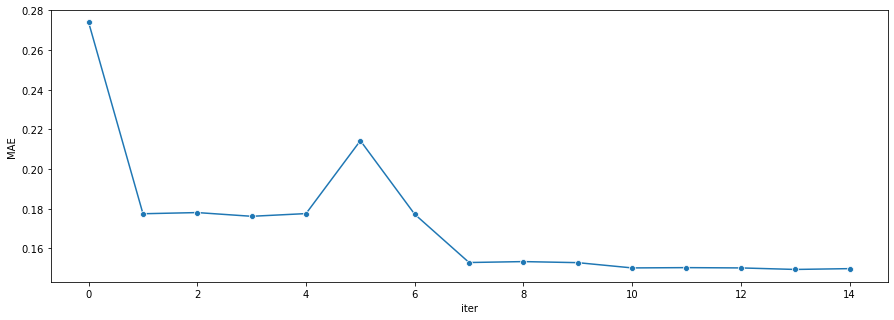

naive: 0.274
zeros: 0.1775
median: 0.1781
frequent: 0.1762
drop_CRN: 0.1776
drop_city: 0.2143
drop_RL: 0.1772
city_r: 0.1529
dummy_cs: 0.1534
rr_cluster: 0.1528
country: 0.1502
g_cluster: 0.1503
pop2rank: 0.1502
rf_model: 0.1494
gb_model: 0.1498


In [134]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=[x for x in range(len(results.values()))], y=list(results.values()), marker='o')
ax.set(ylabel='MAE', xlabel='iter')
plt.show()

for key, value in results.items():
    print('{}: {}'.format(key, np.round(value, 4)))

Обе модели показывают примерно одинаковый результат. RandomForest показывает себя чуть лучше.

## Обработка результатов моделей

In [135]:
# Функция возвращяет результат модели приведенный к формату целевой переменной
def adjusted(y_pred):
    return np.round(y_pred*2)/2

In [136]:
# MAE для обработоного результа RandomForest
results['rf_adj'] = mean_absolute_error(y_test, adjusted(RF_y_pred))
print('MAE:\t',np.round(results['rf_adj'],4))

MAE:	 0.1166


In [137]:
# MAE для обработоного результа GradientBoosting
results['gb_adj'] = mean_absolute_error(y_test, adjusted(GB_y_pred))
print('MAE:\t',np.round(results['gb_adj'],4))

MAE:	 0.1156


Для обработанных результатов, GradientBoosting чуть точнее.

In [138]:
# Разница значений
np.unique(np.absolute(adjusted(RF_y_pred)-adjusted(GB_y_pred)), return_counts=True)

(array([0. , 0.5, 1. ]), array([7493,  498,    5]))

Предсказания отличаются для около 500та случаев. Можно попробовать улучшить результат, усреднив результаты двух моделей.

In [139]:
results['combined'] = mean_absolute_error(y_test, np.round(adjusted(RF_y_pred)+adjusted(GB_y_pred))/2)
print('MAE:\t',np.round(results['combined'],4))

MAE:	 0.1147


In [140]:
# Проверка, что результаты не выбиваются из возможных пределов
np.unique(np.round(adjusted(RF_y_pred)+adjusted(GB_y_pred))/2)

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

## Вывод

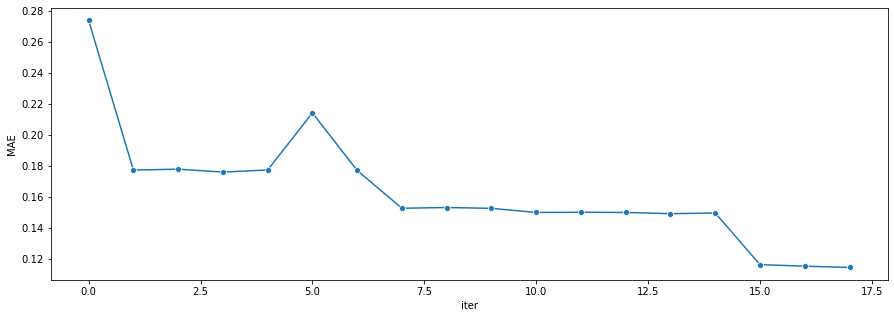

naive: 0.274
zeros: 0.1775
median: 0.1781
frequent: 0.1762
drop_CRN: 0.1776
drop_city: 0.2143
drop_RL: 0.1772
city_r: 0.1529
dummy_cs: 0.1534
rr_cluster: 0.1528
country: 0.1502
g_cluster: 0.1503
pop2rank: 0.1502
rf_model: 0.1494
gb_model: 0.1498
rf_adj: 0.1166
gb_adj: 0.1156
combined: 0.1147


In [141]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=[x for x in range(len(results.values()))], y=list(results.values()), marker='o')
ax.set(ylabel='MAE', xlabel='iter')
plt.show()

for key, value in results.items():
    print('{}: {}'.format(key, np.round(value, 4)))

Обработка результатов моделирование дала существенное снижение MAE.

# Submission

In [142]:
# Формат ответа
sample_submission.sample(3)

,Restaurant_id,Rating
8876,id_8876,1.5
4065,id_4065,1.5
4116,id_4116,2.5


In [143]:
# Проверка размерности
print(sample_submission.shape)
print(data[data.train==0].shape)

(10000, 2)
(10000, 78)


In [144]:
# Предобработка
submission = data[data.train==0].drop(['train'],axis=1)
rest_id = submission.Restaurant_id
submission = submission.drop(['Restaurant_id'],axis=1)

# Предсказание
X_valid = submission.drop('Rating', axis = 1)
predictions = np.round(adjusted(RF.predict(X_valid))+adjusted(GB.predict(X_valid)))/2

In [145]:
# Запись
sample_submission['Restaurant_id'] = rest_id.values
sample_submission['Rating'] = predictions
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_5,4.0
2,id_15,3.0
3,id_31,5.0
4,id_34,4.5
5,id_35,4.0
6,id_38,4.0
7,id_41,3.0
8,id_45,3.0
9,id_46,4.0
